気象庁のサイト
https://www.data.jma.go.jp/cpdinfo/temp/an_wld.html

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mstats
import pystan
%matplotlib inline

In [10]:
plt.style.use("ggplot")

In [11]:
df = pd.read_excel("./data/temperature_series.xlsx")

In [12]:
df.head()

,x,y
0,1891,-0.6291
1,1892,-0.7111
2,1893,-0.7520
3,1894,-0.7008
4,1895,-0.6752


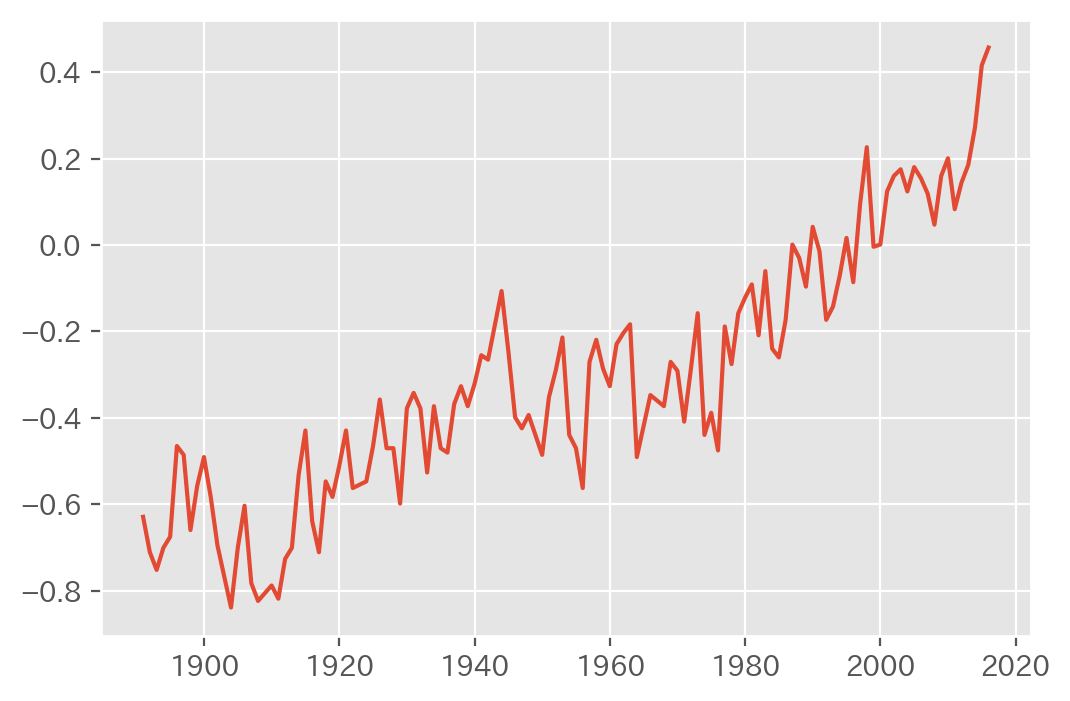

In [13]:
plt.plot(df["x"],df["y"]);

想定：  
「2016までのデータから2017年を予測する」

In [14]:
stan_model = """
data {
  int T;
  int T_new;
  real Y[T];
}

parameters {
  real mu[T];
  real<lower=0> s_mu;
  real<lower=0> s_Y;
}

model {
  for (t in 2:T){
    mu[t] ~ normal(mu[t-1], s_mu);
  }
  
  for (t in 1:T){
    Y[t] ~ normal(mu[t], s_Y);
  }
}

generated quantities {
  real mu_new;
  real Y_new[T+T_new];
  for (t in 1:T){
    Y_new[t] = normal_rng(mu[t], s_Y);
  }
  mu_new = normal_rng(mu[T], s_mu);
  Y_new[T+T_new] = normal_rng(mu_new, s_Y);
}

"""

In [15]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a0e6be88f5ad08ac36cccc34a23b821f NOW.


In [16]:
stan_data = {"T":df.shape[0],"T_new":1, "Y":df["y"]}

In [17]:
fit = sm.sampling(data = stan_data, iter=3000, warmup=1500, seed=123, chains=3)

In [18]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_a0e6be88f5ad08ac36cccc34a23b821f.
3 chains, each with iter=3000; warmup=1500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=4500.

         mean se_mean     sd   2.5%    25%    50%    75%   97.5%  n_eff   Rhat
mu[1]   -0.66  8.6e-4   0.05  -0.77   -0.7  -0.66  -0.63   -0.56   3752    1.0
mu[2]   -0.69  8.6e-4   0.05  -0.78  -0.72  -0.69  -0.66    -0.6   3008    1.0
mu[3]    -0.7  1.4e-3   0.05  -0.79  -0.74   -0.7  -0.67   -0.61   1170    1.0
mu[4]   -0.68  1.0e-3   0.05  -0.77  -0.71  -0.68  -0.65   -0.59   2044    1.0
mu[5]   -0.63  6.8e-4   0.04  -0.72  -0.66  -0.63   -0.6   -0.55   4270    1.0
mu[6]   -0.55  1.9e-3   0.05  -0.65  -0.59  -0.55  -0.52   -0.45    708    1.0
mu[7]   -0.55  1.5e-3   0.05  -0.64  -0.58  -0.55  -0.51   -0.45   1065    1.0
mu[8]   -0.59  8.4e-4   0.05  -0.68  -0.62  -0.59  -0.56    -0.5   3068    1.0
mu[9]   -0.57  7.6e-4   0.04  -0.66   -0.6  -0.57  -0.54   -

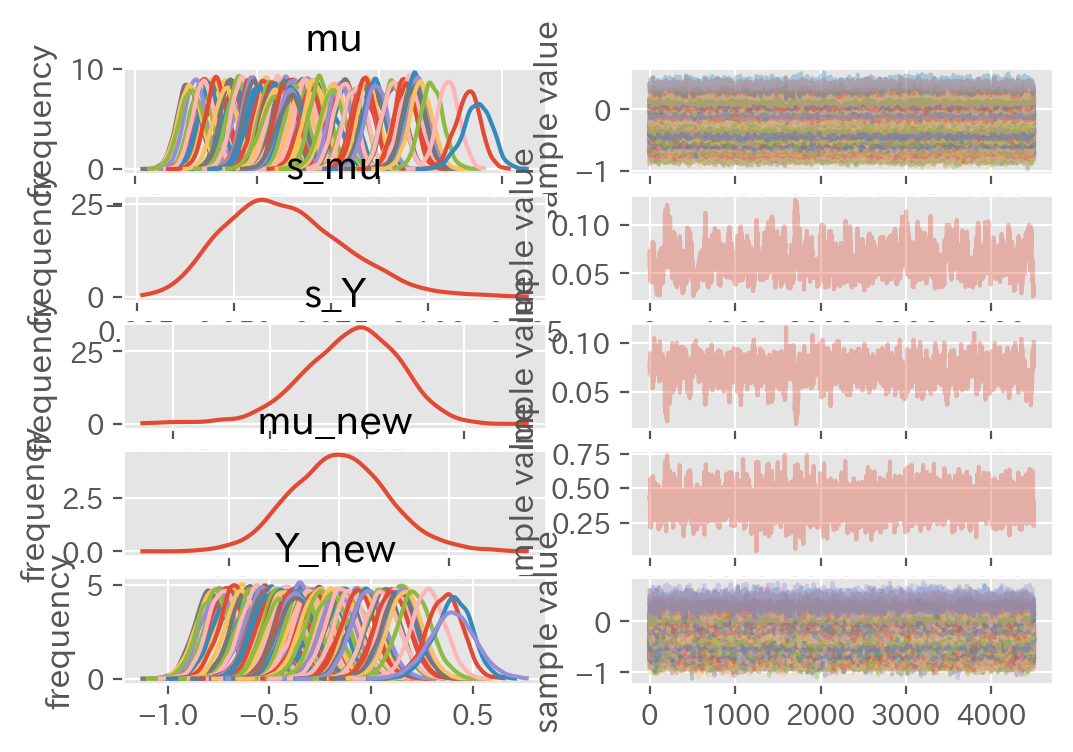

In [19]:
fig = fit.plot()

In [20]:
Y_new_arr = fit.extract("Y_new")["Y_new"]

In [21]:
low_y50, high_y50 = mstats.mquantiles(Y_new_arr, [0.25, 0.75], axis=0)
low_y95, high_y95 = mstats.mquantiles(Y_new_arr, [0.025, 0.975], axis=0)

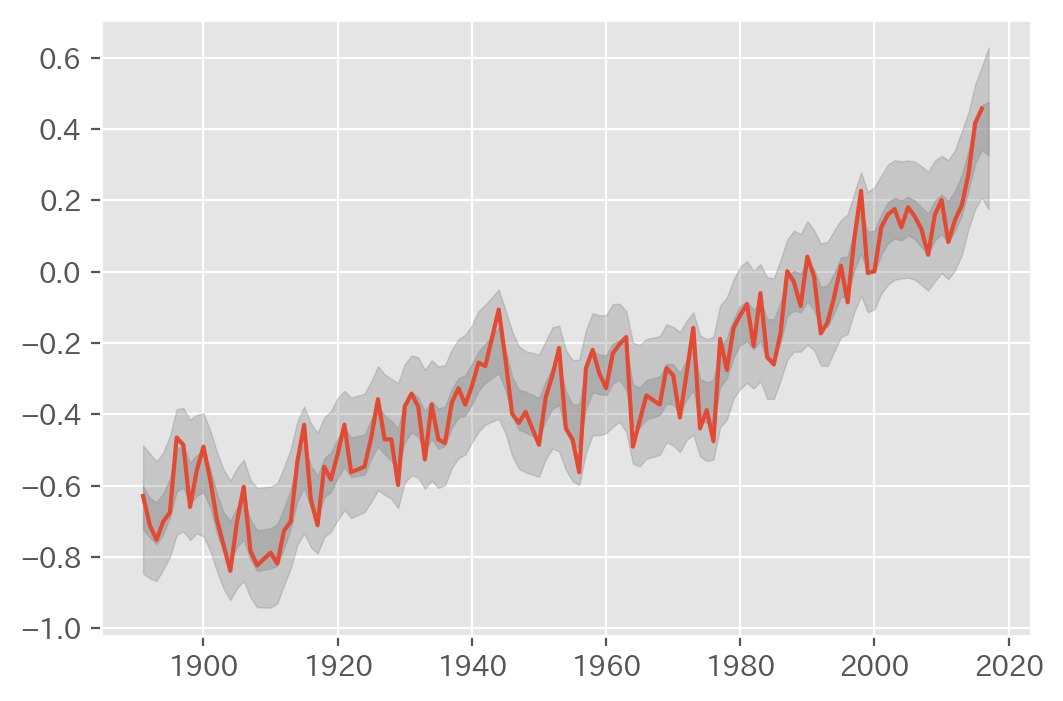

In [22]:
plt.plot(df["x"],df["y"])
x = df["x"].values
x = np.append(x, 2017)
plt.fill_between(x, low_y50, high_y50, alpha=0.6, color="darkgray")
plt.fill_between(x, low_y95, high_y95, alpha=0.3, color="gray")